# Time Series Forecasting

Time series forecasting is widely used in sciences with the intended purpose of predicting the future based on present data. This type of machine learning technique has been used for weather forecasting, glacier melting outlooks, and carbon dioxide concentration predictions. In this tutorial, we will use a dataset from an Ameriflux flux tower located in Willow Creek, Wisconsin. We'll build an Air Temperature Forecast using Linear Regression Modeling. The goal of this exercise is to build a linear regression model using existing training data to accurately predict existing testing data. This is an isolated tutorial that **does not** account for other variables (precipitation, shortwave radiation, etc.) that may have an influence on Air Temperature. While it may not serve as the best predictive model for air temperature, it serves as a first step in linear regression modeling and machine learning. 


## Load and parse the dataset

The Willow Creek flux tower dataset contains meteorological variables such as temperature, wind, precipitation, etc. These values were recorded at an **hourly resolution**. We'll load the netcdf files using `xarray` which contains a function called `open_mfdataset`. This function will open multiple datasets and appends them based on the time dimension. This allows us to merge 3 files each containing an invidivual year of observed data. We'll subset our dataset to the `air_temperature` variable which will leave us with an `xarray.DataArray` object. 

In [1]:
## For data
import pandas as pd
import numpy as np
## For plotting
import matplotlib.pyplot as plt
import xarray as xr

ds = xr.open_mfdataset("/Users/james/Documents/Github/geog473-673/datasets/WCr*")['air_temperature']
ds

<xarray.DataArray 'air_temperature' (time: 26304, longitude: 1, latitude: 1)>
dask.array<concatenate, shape=(26304, 1, 1), dtype=float32, chunksize=(8784, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 45.81
  * longitude  (longitude) float64 -90.08
  * time       (time) datetime64[ns] 2010-01-01T01:00:00 ... 2013-01-01
Attributes:
    units:    Kelvin

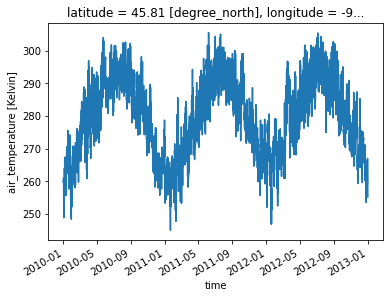

In [2]:
ds.plot()

## Resample to Daily Resolution

Let's aggregate our dataset from an hourly resolution to a daily resolution. `xarray.resample` is the function we'll use for this task. This coarsens the temporal dimension which makes computation easier down the line. 


In [3]:
# Create a Daily Resolution using Xarray

ds_daily = ds.resample(time='1M').mean()
ds_daily

<xarray.DataArray 'air_temperature' (time: 37, longitude: 1, latitude: 1)>
dask.array<stack, shape=(37, 1, 1), dtype=float32, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2010-01-31 2010-02-28 ... 2013-01-31
  * latitude   (latitude) float64 45.81
  * longitude  (longitude) float64 -90.08

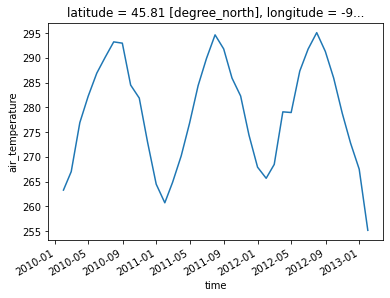

In [4]:
ds_daily.plot()

### Converting the Data

Let's convert the Air Temperature units from degrees Kelvin to degrees Fahrenheit. Then, we are going to convert the object from an `xarray.DataArray` to a `Pandas` timeseries object. 

In [5]:
ds_daily_f = (ds_daily - 273.15) * (9/5) + 32
ds_daily_f

<xarray.DataArray 'air_temperature' (time: 37, longitude: 1, latitude: 1)>
dask.array<add, shape=(37, 1, 1), dtype=float32, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2010-01-31 2010-02-28 ... 2013-01-31
  * latitude   (latitude) float64 45.81
  * longitude  (longitude) float64 -90.08

When we convert to a pandas dataframe, notice how we have to use `xarray.isel` to grab the first (and only) latitude/longitude values. The dimensions of the `ds_daily_f` dataframe are 1097 time values x 1 longitude value x 1 latitude value. Pandas requires arrays to be 1 dimension. Thus, by using `xarray.isel` we are removing the latitude/longitude dimension from the dataframe and distilling our `ds_daily_f` shape to 1097. This is alright because we know we are dealing with a time series dataset at a single point that remains constant throughout hte timeseries.

In [6]:
temp_daily = pd.DataFrame(index=pd.to_datetime(ds_daily_f.time.values),data=ds_daily_f.isel(latitude=0, longitude=0).values, columns=['airT'])
temp_daily

,airT
2010-01-31,14.273504
2010-02-28,20.989174
2010-03-31,38.805096
2010-04-30,48.379955
2010-05-31,56.782135
2010-06-30,62.509804
2010-07-31,68.157982
2010-08-31,67.693420
2010-09-30,52.452255
2010-10-31,47.725445


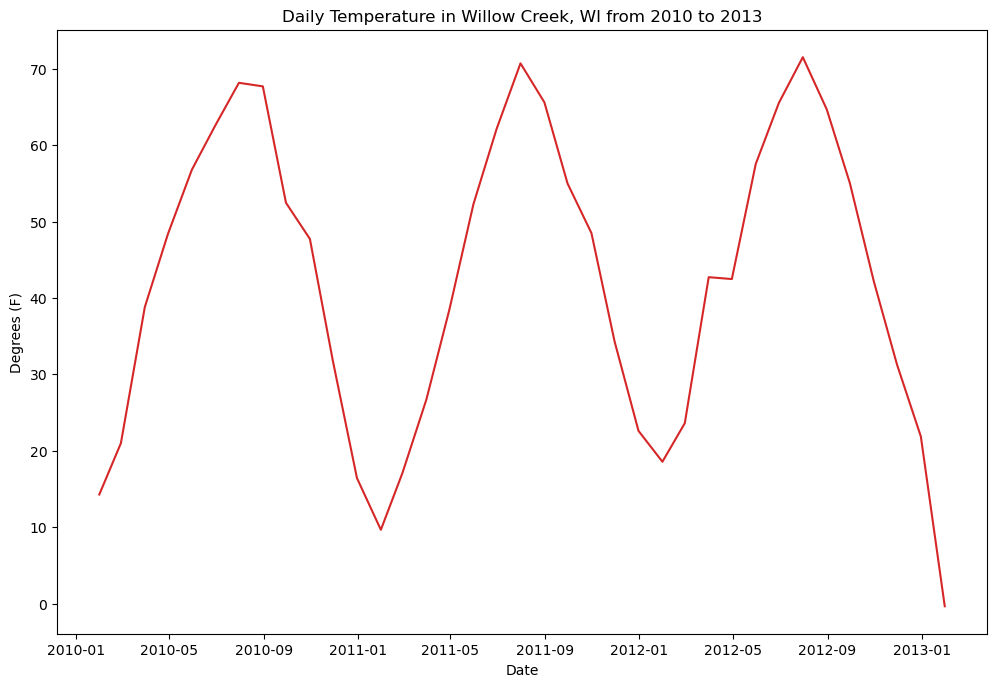

In [7]:
# Plot the daily temperature change via pandas
plt.figure(figsize=(12,8), dpi=100)
plt.plot(temp_daily.index, temp_daily.airT, color='tab:red')
plt.gca().set(title="Daily Temperature in Willow Creek, WI from 2010 to 2013", xlabel='Date', ylabel="Degrees (F)")
plt.show()

Some distinguishable patterns appear when we plot the data. Just as we expect, the average daily temperature in the northern hemisphere reaches it's peak in the summer. Conversely, the average daily temperature reaches it's lowest point in the winter. We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

### Time Series Decomposition

We can decompose our daily time series to a seasonal decomposition using the `statsmodels` `seasonal_decompose` function. Each season is roughly 91 days, so let's examine the decomposition when we use a period of 91 days. 

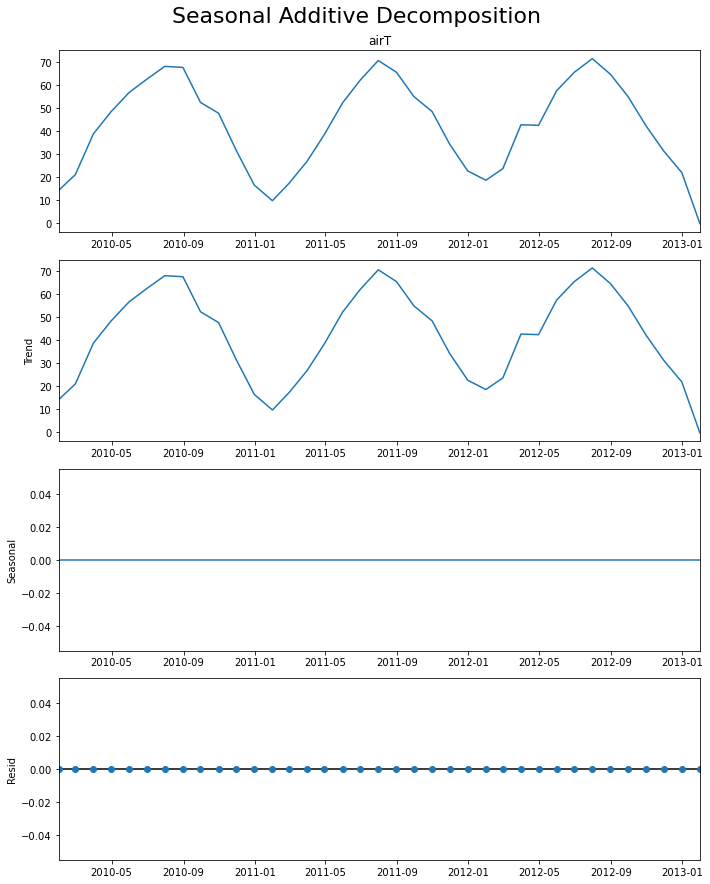

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition for 
result_add = seasonal_decompose(temp_daily.airT, model='additive', extrapolate_trend='freq', period=1)

# Plot
plt.rcParams.update({'figure.figsize': (10,12)})
result_add.plot().suptitle('Seasonal Additive Decomposition', fontsize=22, y=1.02)
plt.show()

# SARIMAX Regression Modeling

SARIMAX(Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors) is an updated version of the ARIMA model. ARIMA includes an autoregressive integrated moving average, while SARIMAX includes seasonal effects and eXogenous factors with the autoregressive and moving average component in the model. Therefore, we can say SARIMAX is a seasonal equivalent model like SARIMA and Auto ARIMA.

Another seasonal equivalent model holds the seasonal pattern; it can also deal with external effects. This feature of the model differs from other models. For example, in a time series, the temperature has seasonal effects like it is low in winter, high in summers. Still, with the effect of external factors like humidity, the temperature in winter is increased and also due to rain, there is a chance of lower temperature. We can’t predict the exact value for these factors if they do not appear in a cyclic or any seasonal behaviour. Other models are not capable of dealing with this kind of data.

In the SARIMAX models parameter, we need to provide two kinds of orders. The first one is similar to the ARIMAX model (p, d, q), and the other is to specify the effect of the seasonality; we call this order a seasonal order in which we are required to provide four numbers.

`(Seasonal AR specification, Seasonal Integration order, Seasonal MA, Seasonal periodicity)`

*to read more on this, please visit [this link](https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/)*


### Splitting the dataset

First we'll need to split our dataset into a training dataset and a testing dataset. We'll train the model with the training dataset and then predict temperature values during the testing time period

In [11]:
train = temp_daily['2010-01-01':'2012-05-31']
test = temp_daily['2012-06-01':'2012-12-31']

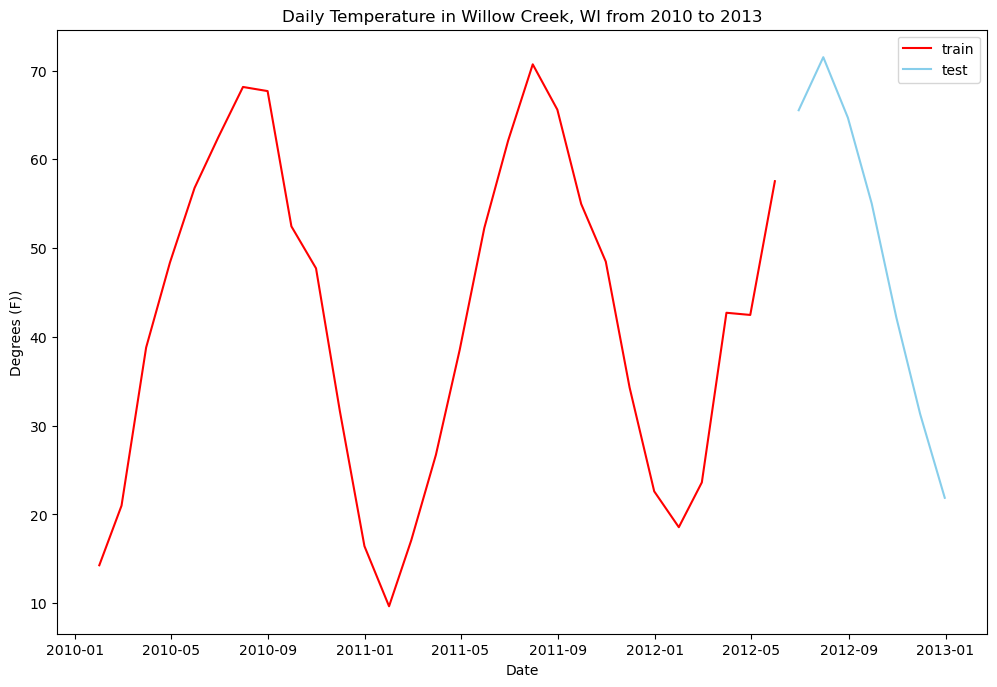

In [12]:
# Plot the daily temperature change via pandas
fig, ax = plt.subplots(figsize=(12,8), dpi=100)
plt.plot(train.index, train.airT, color='red', label='train')
plt.plot(test.index, test.airT, color='skyblue', label='test')
plt.gca().set(title="Daily Temperature in Willow Creek, WI from 2010 to 2013", xlabel='Date', ylabel="Degrees (F))")
ax.legend()
plt.show()

### Parameter Selection

We are going to apply one of the most commonly used method for time-series forecasting, known as SARIMA, which stands for Seasonal Autoregressive Integrated Moving Average. SARIMA models are denoted with the notation SARIMA(p,d,q)(P,D,Q,s). These three parameters account for seasonality, trend, and noise in data:

We will use a “grid search” to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal SARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality.

In [13]:
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


### Akaike Information Criterion

The Akaike information criterion (AIC) is an estimator of prediction error and thereby relative quality of statistical models for a given set of data. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value. To do this, we'll run through every combination of inputs and choose the lowest AIC.

In [16]:
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

# create blank AIC table to store AIC values
sarimax = []
aic = []


for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(train.airT,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        results = mod.fit(disp=False)
        sarimax.append('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        aic.append(results.aic)


In [17]:
param_data = [sarimax, aic]
param_sel = pd.DataFrame(data=np.transpose(param_data),columns=['sarimax_result', 'aic'])
param_sel

,sarimax_result,aic
0,"SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:296.3705...",296.3705441031724
1,"SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:168.4221...",168.42214603378716
2,"SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:109.2417...",109.24174839237534
3,"SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:29.28177...",29.281773148216637
4,"SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:117.3798...",117.37983804884684
...,...,...
59,"SARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:-10.6665...",-10.666561415671612
60,"SARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:97.23234...",97.23234246738936
61,"SARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:91.61790...",91.61790597777568
62,"SARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:25.44265...",25.442654107197093


In [19]:
param_sel['aic'] = pd.to_numeric(param_sel['aic'])
aic_idxmin = param_sel['aic'].idxmin()
print(aic_idxmin)

27


In [20]:
param_sel['sarimax_result'].loc[[aic_idxmin]]

27    SARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:-16.3218...
Name: sarimax_result, dtype: object

Thus we see that our best fitting parameter selection is a **SARIMAX order of 1,1,1 and a seasonal order of 0,1,1,12**. Now we can plug in these parameters into our `statsmodels` `SARIMAX` function!

## Fitting the Model

Using our parameters above, we can now use `statsmodels` `sarimax` function. This 

In [21]:
nan_test = test.airT.replace('*',np.nan)
nan_test

2012-06-30    65.535934
2012-07-31    71.513481
2012-08-31    64.687241
2012-09-30    55.025970
2012-10-31    42.192070
2012-11-30    31.314234
2012-12-31    21.872309
Name: airT, dtype: float32

In [22]:
# Import the statsmodels library for using SARIMAX model
import statsmodels.api as sm

# Fit the SARIMAX model using optimal parameters
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(4, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit(disp=False)

In [23]:
pred = results.get_prediction(start=test.index[0], end=test.index[-1],dynamic=False)
pred_ci = pred.conf_int()

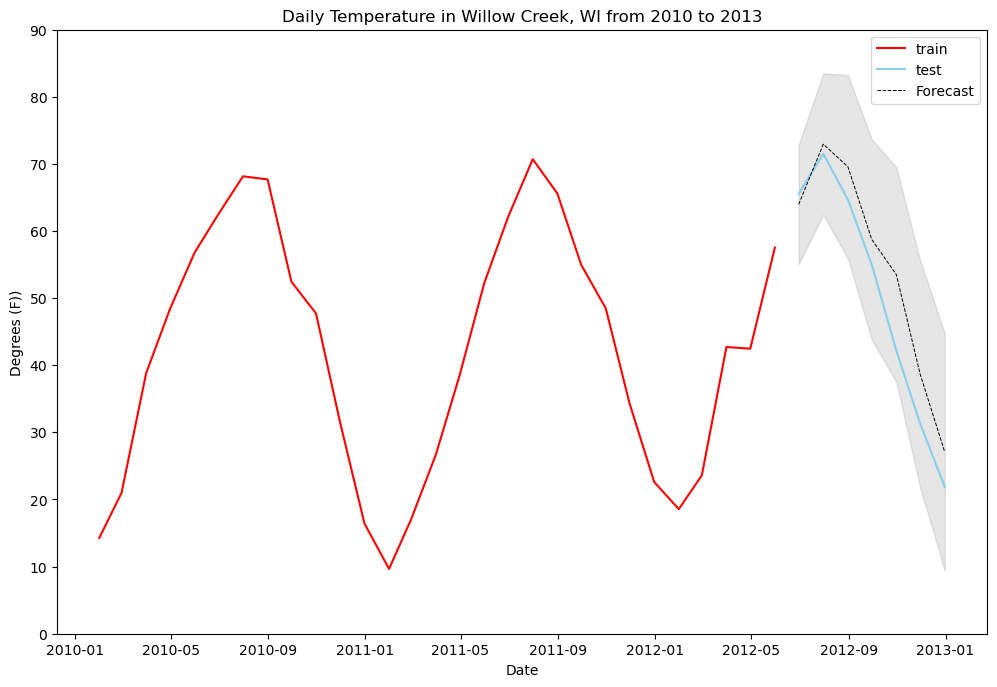

In [24]:
# Plot the daily temperature change via pandas
fig, ax = plt.subplots(figsize=(12,8), dpi=100)
plt.plot(train.index, train.airT, color='red', label='train')
plt.plot(test.index, test.airT, color='skyblue', label='test')
plt.plot(pred.predicted_mean.index, pred.predicted_mean.values, color='k',label='Forecast', linestyle='dashed', linewidth='0.7')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='gray', alpha=.2)
plt.ylim([0,90])
plt.gca().set(title="Daily Temperature in Willow Creek, WI from 2010 to 2013", xlabel='Date', ylabel="Degrees (F))")
ax.legend()
plt.show()


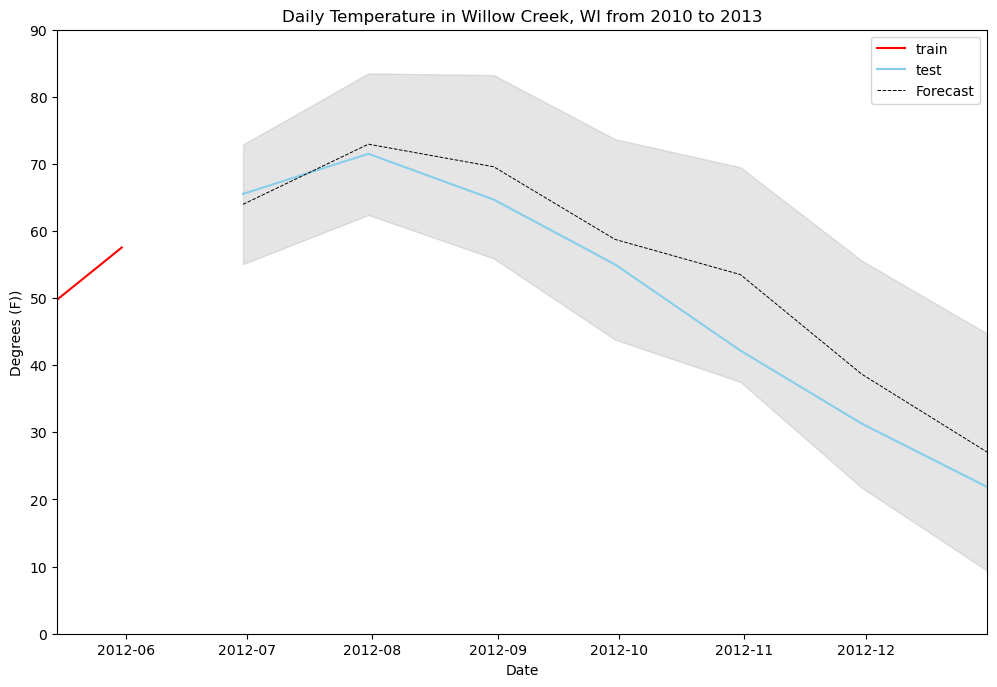

In [25]:
# Plot the daily temperature change via pandas
fig, ax = plt.subplots(figsize=(12,8), dpi=100)
plt.plot(train.index, train.airT, color='red', label='train')
plt.plot(test.index, test.airT, color='skyblue', label='test')
plt.plot(pred.predicted_mean.index, pred.predicted_mean.values, color='k',label='Forecast', linestyle='dashed', linewidth='0.7')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='gray', alpha=.2)
plt.ylim([0,90])
plt.gca().set(title="Daily Temperature in Willow Creek, WI from 2010 to 2013", xlabel='Date', ylabel="Degrees (F))")
ax.set_xlim(pd.Timestamp('2012-05-15'), pd.Timestamp('2012-12-31'))
ax.legend()
plt.show()

In [511]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

In [512]:
import statsmodels as sm

In [521]:
model_ar = sm.tsa.ar_model.AutoReg(train.airT, lags=365)
model_ar_fit = model_ar.fit()

In [522]:
predictions = model_ar_fit.predict(start=test.index[0],end=test.index[-1])


In [523]:
test

,airT
2012-06-01,54.738731
2012-06-02,59.440441
2012-06-03,63.612061
2012-06-04,64.617310
2012-06-05,61.496147
...,...
2012-12-27,16.002148
2012-12-28,15.696070
2012-12-29,15.993744
2012-12-30,13.668213


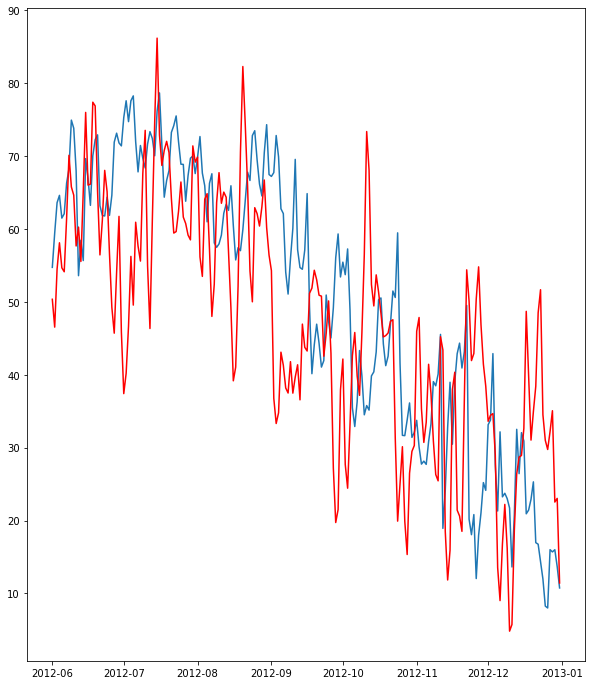

In [524]:
plt.plot(test) # taken data as test
plt.plot(predictions,color='red') # predicted data